<a href="https://colab.research.google.com/github/mrlocastellani/pamap2/blob/main/pamap2_com_descri%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

Permite acesso do notebook ao Google Drive, onde estão armazenados os datasets

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Categoriza e agrupa as colunas, juntamentecom todos os arquivos dos datasets que estão inicialmente separados por "sujeitos"

In [ ]:
list_of_files = [r"/content/drive/MyDrive/ColabData/Protocol/subject101.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject102.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject103.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject104.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject105.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject106.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject107.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject108.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject109.dat"]

subjectID = [1,2,3,4,5,6,7,8,9]

activityIDdict = {0: 'transient',
                  1: 'lying',
                  2: 'sitting',
                  3: 'standing',
                  4: 'walking',
                  5: 'running',
                  6: 'cycling',
                  7: 'Nordic_walking',
                  9: 'watching_TV',
                  10: 'computer_work',
                  11: 'car driving',
                  12: 'ascending_stairs',
                  13: 'descending_stairs',
                  16: 'vacuum_cleaning',
                  17: 'ironing',
                  18: 'folding_laundry',
                  19: 'house_cleaning',
                  20: 'playing_soccer',
                  24: 'rope_jumping' }

colNames = ["timestamp", "activityID","heartrate"]

IMUhand = ['handTemperature',
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3',
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3',
           'handGyro1', 'handGyro2', 'handGyro3',
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature',
            'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
            'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
            'chestGyro1', 'chestGyro2', 'chestGyro3',
            'chestMagne1', 'chestMagne2', 'chestMagne3',
            'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature',
            'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
            'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3',
            'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
            'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
            'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = colNames + IMUhand + IMUchest + IMUankle  #all columns in one list

len(columns)

54

agrupa os datasets antes separados em arquivos distintos em único arquivo

In [ ]:
dataCollection = pd.DataFrame()
for file in list_of_files:
    procData = pd.read_table(file, header=None, sep='\s+')
    procData.columns = columns
    procData['subject_id'] = int(file[-5])
    dataCollection = pd.concat([dataCollection, procData], ignore_index=True)

dataCollection.reset_index(drop=True, inplace=True)
dataCollection.head()

Remove colunas não utilizadas
remove atividade de transição já que ela não é importante para o modelo

In [ ]:
def dataCleaning(dataCollection):
        dataCollection = dataCollection.drop(['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
                                             'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
                                             'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'],
                                             axis = 1)  # removal of orientation columns according to the readme
        dataCollection = dataCollection.drop(dataCollection[dataCollection.activityID == 0].index) #removal of any row of activity 0 as it is transient activity which it is not used
        dataCollection = dataCollection.apply(pd.to_numeric, errors = 'coerce') #removal of non numeric data in cells
        dataCollection = dataCollection.interpolate() #removal of any remaining NaN value cells by constructing new data points in known set of data points

        return dataCollection

In [ ]:
dataCol = dataCleaning(dataCollection)
dataCol.reset_index(drop = True, inplace = True)
dataCol.head(10)

In [ ]:
for i in range(0, 4):
    dataCol.loc[:3, "heartrate"] = 100

Exporta o modelo agrupado para um arquivo pamap_data_collection.csv, isso garante que vamos manter essa base intacta e mesmo que o ambiente de execução do notebook seja desligado, quando quisermos voltar não precisamos rodar todos os passos de junção de dados novamente, econimizando tempo

In [ ]:
dataCol.to_csv('/content/drive/MyDrive/ColabData/pamap_data_collection.csv', index=False)

In [ ]:
dataCol.head()

Busca e carrega o csv dos dados salvos no passo anterior

In [3]:
dataCollection = pd.read_csv('/content/drive/MyDrive/ColabData/pamap_data_collection.csv')
print(dataCollection)

         timestamp  activityID  heartrate  handTemperature  handAcc16_1  \
0            37.66           1      100.0           30.375      2.21530   
1            37.67           1      100.0           30.375      2.29196   
2            37.68           1      100.0           30.375      2.29090   
3            37.69           1      100.0           30.375      2.21800   
4            37.70           1      100.0           30.375      2.30106   
...            ...         ...        ...              ...          ...   
1942867      95.06          24      162.0           25.125      4.99466   
1942868      95.07          24      162.0           25.125      5.02764   
1942869      95.08          24      162.0           25.125      5.06409   
1942870      95.09          24      162.0           25.125      5.13914   
1942871      95.10          24      162.0           25.125      5.00812   

         handAcc16_2  handAcc16_3  handAcc6_1  handAcc6_2  handAcc6_3  ...  \
0            8.27915 

In [4]:
dataCollection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1942872 entries, 0 to 1942871
Data columns (total 43 columns):
 #   Column            Dtype  
---  ------            -----  
 0   timestamp         float64
 1   activityID        int64  
 2   heartrate         float64
 3   handTemperature   float64
 4   handAcc16_1       float64
 5   handAcc16_2       float64
 6   handAcc16_3       float64
 7   handAcc6_1        float64
 8   handAcc6_2        float64
 9   handAcc6_3        float64
 10  handGyro1         float64
 11  handGyro2         float64
 12  handGyro3         float64
 13  handMagne1        float64
 14  handMagne2        float64
 15  handMagne3        float64
 16  chestTemperature  float64
 17  chestAcc16_1      float64
 18  chestAcc16_2      float64
 19  chestAcc16_3      float64
 20  chestAcc6_1       float64
 21  chestAcc6_2       float64
 22  chestAcc6_3       float64
 23  chestGyro1        float64
 24  chestGyro2        float64
 25  chestGyro3        float64
 26  chestMagne1   

In [ ]:
plt.figure(figsize=(8, 6))
dataCollection['activityID'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Histogram of entries by Activity ID')
plt.xlabel('Activity ID')
plt.ylabel('Count')
plt.show()

In [ ]:
dataCollection

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
0,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.863600,-58.369600,1
1,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.319700,-58.365600,1
2,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.784200,-58.611900,1
3,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.102800,-57.879900,1
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.122500,-57.884700,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942867,95.06,24,162.0,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,...,9.41274,-2.26922,-1.759580,0.021288,-0.012885,0.005878,-45.7855,-0.831734,-0.170139,9
1942868,95.07,24,162.0,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,...,9.33733,-2.23908,-1.834950,0.010715,0.003629,-0.004235,-46.0331,-0.817288,0.538134,9
1942869,95.08,24,162.0,25.125,5.06409,5.71370,5.48491,4.97981,5.87584,5.45738,...,9.32243,-2.23905,-1.804610,-0.016939,-0.035176,-0.002309,-45.5140,-1.229410,0.540438,9
1942870,95.09,24,162.0,25.125,5.13914,5.63724,5.48629,4.97690,5.69448,5.29167,...,9.38220,-2.26938,-1.880500,-0.028069,-0.036457,-0.007076,-45.9093,-0.565555,0.680109,9


Aqui determinamos as atividades que vão ser treinadas, utilizamoso LabelEncoder para transformar as actividades em um range de 0 a 6 pois alguns modelos, principalmente de RNN aceita os lables númericos nesse range

In [5]:
valid_activity_ids = [1, 2, 3, 4, 16, 17]

data = dataCollection[dataCollection['activityID'].isin(valid_activity_ids)].copy()

label_encoder = LabelEncoder()

data['activityID'] = label_encoder.fit_transform(data['activityID'])

Aqui foi o primeiro modelo para teste do código
Ao invés de utilizar k-fold utilizei a técnica de buscar e separar dois subjects para o teste de 1N

Epoch 1/50
28275/28275 [==============================] - 260s 9ms/step - loss: 0.1729 - accuracy: 0.9464 - val_loss: 1.9438 - val_accuracy: 0.6139
Epoch 2/50
28275/28275 [==============================] - 261s 9ms/step - loss: 0.0773 - accuracy: 0.9749 - val_loss: 2.7707 - val_accuracy: 0.5986
Epoch 3/50
28275/28275 [==============================] - 250s 9ms/step - loss: 0.0603 - accuracy: 0.9801 - val_loss: 3.2843 - val_accuracy: 0.5803
Epoch 4/50
9865/9865 [==============================] - 30s 3ms/step - loss: 1.9438 - accuracy: 0.6139
Test accuracy: 0.6139


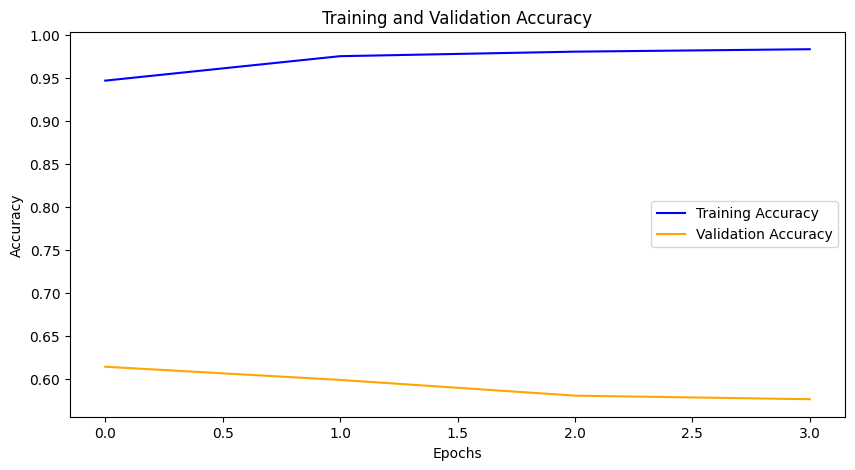

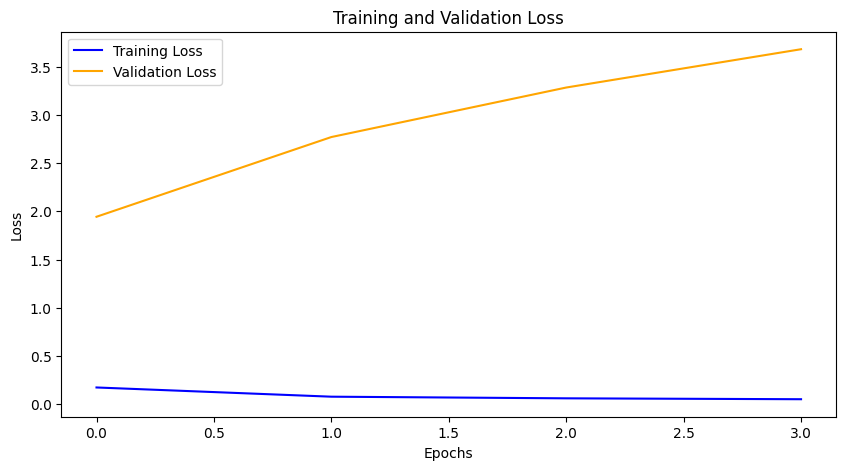

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd

all_subjects = data['subject_id'].unique()
np.random.shuffle(all_subjects)

num_test_subjects = 2
subjects_to_test = all_subjects[:num_test_subjects]

mask = data['subject_id'].isin(subjects_to_test)
data_to_test = data[mask].copy()
data_to_train = data[~mask].copy()

feature_columns = [
    'heartrate', 'handTemperature', 'handAcc16_1', 'handAcc16_2', 'handAcc16_3',
    'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 'handGyro1', 'handGyro2', 'handGyro3',
    'handMagne1', 'handMagne2', 'handMagne3', 'chestTemperature', 'chestAcc16_1',
    'chestAcc16_2', 'chestAcc16_3', 'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
    'chestGyro1', 'chestGyro2', 'chestGyro3', 'chestMagne1', 'chestMagne2',
    'chestMagne3', 'ankleTemperature', 'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
    'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
    'ankleMagne1', 'ankleMagne2', 'ankleMagne3'
]
label_column = 'activityID'

X_train = data_to_train[feature_columns].values
y_train = data_to_train[label_column].values

X_test = data_to_test[feature_columns].values
y_test = data_to_test[label_column].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, validation_data=(X_test, y_test_one_hot), callbacks=[early_stop])

loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Test accuracy: {accuracy:.4f}')

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Como o modelo acima funcionou, pensei em criar um treinamento que testa várias possibilidade de configuração, aqui ainda não estou utilizando o k-fold, por esquecimento mesmo :)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd

num_filters = [64, 128]
filter_sizes = [3, 5, 7]
pool_sizes = [2, 3]
num_dense_neurons = [64, 128]

best_val_accuracy = 0
best_model_config = {}

for filters in num_filters:
    for size in filter_sizes:
        for pool_size in pool_sizes:
            for dense_neurons in num_dense_neurons:
                model = Sequential()
                model.add(Conv1D(filters, size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
                model.add(MaxPooling1D(pool_size))
                model.add(Conv1D(filters, size, activation='relu'))
                model.add(MaxPooling1D(pool_size))
                model.add(GlobalMaxPooling1D())
                model.add(Dense(dense_neurons, activation='relu'))
                model.add(Dropout(0.5))
                model.add(Dense(6, activation='softmax'))

                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

                early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

                history = model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, validation_data=(X_test, y_test_one_hot), callbacks=[early_stop])

                _, val_accuracy = model.evaluate(X_test, y_test_one_hot)

                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_model_config = {
                        'filters': filters,
                        'size': size,
                        'pool_size': pool_size,
                        'dense_neurons': dense_neurons
                    }

print("Melhor configuração encontrada:", best_model_config)


Epoch 1/50
28275/28275 [==============================] - 233s 8ms/step - loss: 0.2082 - accuracy: 0.9359 - val_loss: 1.6702 - val_accuracy: 0.6208
Epoch 2/50
28275/28275 [==============================] - 235s 8ms/step - loss: 0.1010 - accuracy: 0.9678 - val_loss: 3.1213 - val_accuracy: 0.5538
Epoch 3/50
28275/28275 [==============================] - 225s 8ms/step - loss: 0.0788 - accuracy: 0.9746 - val_loss: 2.9039 - val_accuracy: 0.5658
Epoch 4/50
9865/9865 [==============================] - 28s 3ms/step - loss: 1.6702 - accuracy: 0.6208
Epoch 1/50
28275/28275 [==============================] - 208s 7ms/step - loss: 0.1664 - accuracy: 0.9469 - val_loss: 1.5440 - val_accuracy: 0.6315
Epoch 2/50
28275/28275 [==============================] - 231s 8ms/step - loss: 0.0761 - accuracy: 0.9749 - val_loss: 2.5524 - val_accuracy: 0.5664
Epoch 3/50
28275/28275 [==============================] - 230s 8ms/step - loss: 0.0613 - accuracy: 0.9795 - val_loss: 3.2086 - val_accuracy: 0.5526
Epoch 4/5

# A melhor configuração de modelo elencado acima foi
# {'filters': 128, 'size': 7, 'pool_size': 2, 'dense_neurons': 128}

A ideia é treinar o modelo com essas configurações e ver os resultados, aqui já estou separados dois subjects que serão testados após todo treinamento de forma isolada para poder apresentar ao modelo dados nunca vistos antes e validar a eficacia do modelo.

1. Separo dois subjects
2. Os dados para o modelo (sem os subjects separados) aplico o k-fold para dar dados de forma aleatória no treinamento do modelo
3. A ideia é rodar mais um teste após esse, mudando o EarlyStop para o patiente 5, se der tempo.. para ver se temos resultados melhores **negrito**

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Seus dados e processamento anterior

all_subjects = data['subject_id'].unique()
np.random.shuffle(all_subjects)

num_test_subjects = 2
subjects_to_test = all_subjects[:num_test_subjects]

mask = data['subject_id'].isin(subjects_to_test)
data_to_test = data[mask].copy()
data_to_train = data[~mask].copy()

feature_columns = ['heartrate', 'handTemperature',
       'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3', 'handMagne1',
       'handMagne2', 'handMagne3', 'chestTemperature', 'chestAcc16_1',
       'chestAcc16_2', 'chestAcc16_3',  'chestGyro1', 'chestGyro2', 'chestGyro3', 'chestMagne1',
       'chestMagne2', 'chestMagne3', 'ankleTemperature', 'ankleAcc16_1',
       'ankleAcc16_2', 'ankleAcc16_3', 'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 'ankleMagne1',
       'ankleMagne2', 'ankleMagne3', 'subject_id']

label_column = 'activityID'

X = data_to_train[feature_columns].values
y = data_to_train[label_column].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = X.reshape(X.shape[0], X.shape[1], 1)

y_one_hot = to_categorical(y)

# Número de folds para o K-Fold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

# Listas para armazenar resultados de métricas
all_train_acc, all_val_acc, all_train_loss, all_val_loss = [], [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]

    filters = 128
    size = 7
    pool_size = 2
    dense_neurons = 128

    model = Sequential()
    model.add(Conv1D(filters, size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size))
    model.add(Conv1D(filters, size, activation='relu'))
    model.add(MaxPooling1D(pool_size))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

    all_train_acc.append(history.history['accuracy'])
    all_val_acc.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Training Accuracy', color='blue')
    plt.plot(val_acc, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

KeyboardInterrupt: ignored

Exception ignored in: <function _xla_gc_callback at 0x7b385db98670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Epoch 1/50
28659/28659 [==============================] - 164s 6ms/step - loss: 0.0779 - accuracy: 0.9761 - val_loss: 3.9420 - val_accuracy: 0.6496
Epoch 2/50
28659/28659 [==============================] - 173s 6ms/step - loss: 0.0324 - accuracy: 0.9894 - val_loss: 4.4560 - val_accuracy: 0.6704
Epoch 3/50
28659/28659 [==============================] - 153s 5ms/step - loss: 0.0264 - accuracy: 0.9917 - val_loss: 6.4941 - val_accuracy: 0.6678
Epoch 4/50
28659/28659 [==============================] - 173s 6ms/step - loss: 0.0226 - accuracy: 0.9932 - val_loss: 7.7711 - val_accuracy: 0.6492


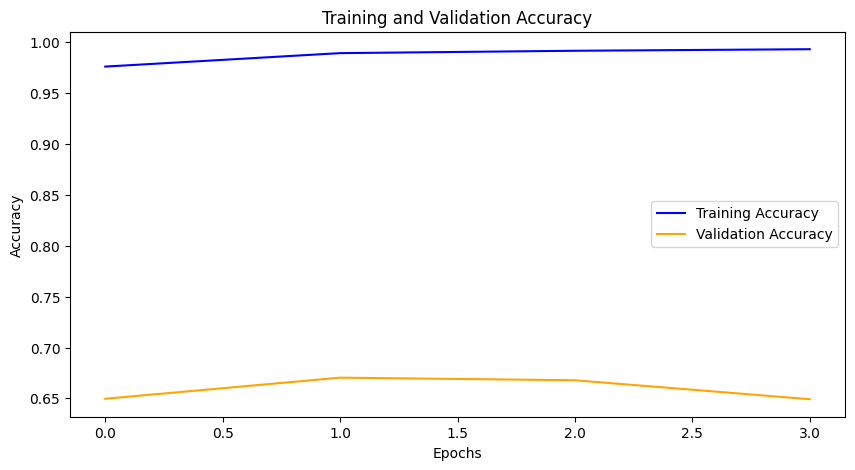

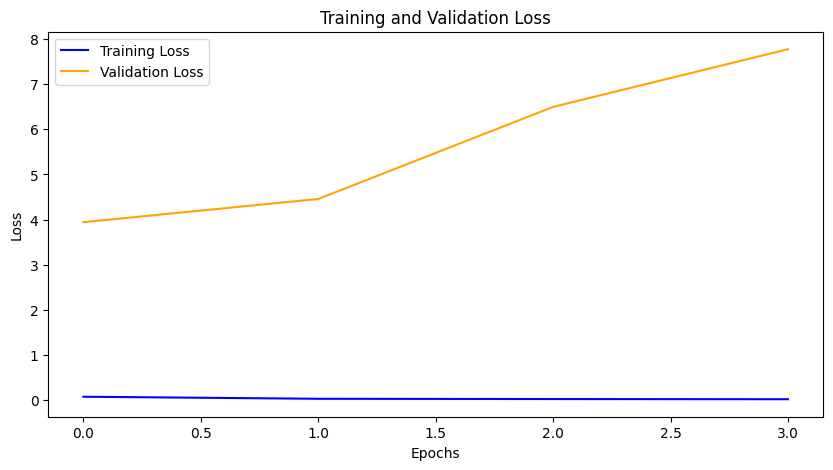

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd

all_subjects = data['subject_id'].unique()
np.random.shuffle(all_subjects)

num_test_subjects = 2
subjects_to_test = all_subjects[:num_test_subjects]

mask = data['subject_id'].isin(subjects_to_test)
data_to_test = data[mask].copy()
data_to_train = data[~mask].copy()

feature_columns = ['heartrate', 'handTemperature',
       'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3', 'handMagne1',
       'handMagne2', 'handMagne3', 'chestTemperature', 'chestAcc16_1',
       'chestAcc16_2', 'chestAcc16_3',  'chestGyro1', 'chestGyro2', 'chestGyro3', 'chestMagne1',
       'chestMagne2', 'chestMagne3', 'ankleTemperature', 'ankleAcc16_1',
       'ankleAcc16_2', 'ankleAcc16_3', 'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 'ankleMagne1',
       'ankleMagne2', 'ankleMagne3', 'subject_id']

label_column = 'activityID'

X_train = data_to_train[feature_columns].values
y_train = data_to_train[label_column].values

X_test = data_to_test[feature_columns].values
y_test = data_to_test[label_column].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

filters = 128
size = 7
pool_size = 2
dense_neurons = 128

model = Sequential()
model.add(Conv1D(filters, size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size))
model.add(Conv1D(filters, size, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(GlobalMaxPooling1D())
model.add(Dense(dense_neurons, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, validation_data=(X_test, y_test_one_hot), callbacks=[early_stop])

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



Epoch 1/50
29034/29034 [==============================] - 174s 6ms/step - loss: 0.0873 - accuracy: 0.9727 - val_loss: 4.4107 - val_accuracy: 0.7553
Epoch 2/50
29034/29034 [==============================] - 170s 6ms/step - loss: 0.0358 - accuracy: 0.9886 - val_loss: 4.6919 - val_accuracy: 0.7502
Epoch 3/50
29034/29034 [==============================] - 169s 6ms/step - loss: 0.0281 - accuracy: 0.9912 - val_loss: 6.6056 - val_accuracy: 0.7639
Epoch 4/50
29034/29034 [==============================] - 171s 6ms/step - loss: 0.0247 - accuracy: 0.9926 - val_loss: 5.5042 - val_accuracy: 0.7633
Epoch 5/50
29034/29034 [==============================] - 169s 6ms/step - loss: 0.0236 - accuracy: 0.9931 - val_loss: 4.9832 - val_accuracy: 0.7759
Epoch 6/50
29034/29034 [==============================] - 167s 6ms/step - loss: 0.0225 - accuracy: 0.9937 - val_loss: 8.3208 - val_accuracy: 0.7534


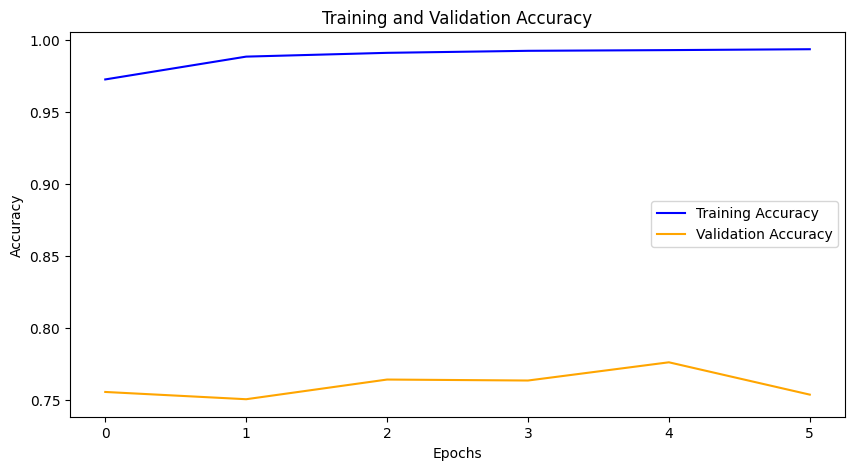

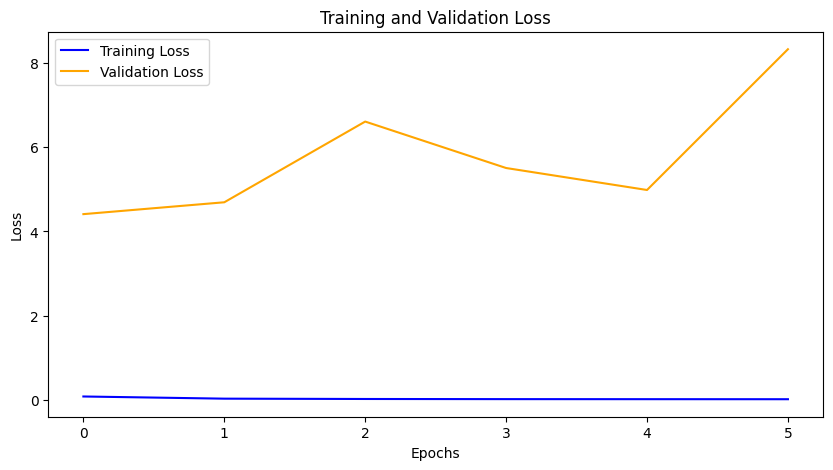

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd

all_subjects = data['subject_id'].unique()
np.random.shuffle(all_subjects)

num_test_subjects = 2
subjects_to_test = all_subjects[:num_test_subjects]

mask = data['subject_id'].isin(subjects_to_test)
data_to_test = data[mask].copy()
data_to_train = data[~mask].copy()

feature_columns = ['heartrate', 'handTemperature',
       'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3', 'handMagne1',
       'handMagne2', 'handMagne3', 'chestTemperature', 'chestAcc16_1',
       'chestAcc16_2', 'chestAcc16_3',  'chestGyro1', 'chestGyro2', 'chestGyro3', 'chestMagne1',
       'chestMagne2', 'chestMagne3', 'ankleTemperature', 'ankleAcc16_1',
       'ankleAcc16_2', 'ankleAcc16_3', 'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 'ankleMagne1',
       'ankleMagne2', 'ankleMagne3', 'subject_id']

label_column = 'activityID'

X_train = data_to_train[feature_columns].values
y_train = data_to_train[label_column].values

X_test = data_to_test[feature_columns].values
y_test = data_to_test[label_column].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

filters = 128
size = 7
pool_size = 2
dense_neurons = 128

model = Sequential()
model.add(Conv1D(filters, size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size))
model.add(Conv1D(filters, size, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(GlobalMaxPooling1D())
model.add(Dense(dense_neurons, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, validation_data=(X_test, y_test_one_hot), callbacks=[early_stop])

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Depois que o modelo acima estiver treinado vou usar ele para validar os testes com os dois subjects separados, a fim de validar o modelo com dados nunca vistos antes

In [ ]:
separate_test_data = data_to_test

X_separate_test = separate_test_data[feature_columns].values
y_separate_test = separate_test_data[label_column].values

X_separate_test_scaled = scaler.transform(X_separate_test)
X_separate_test_scaled = X_separate_test_scaled.reshape(X_separate_test_scaled.shape[0], 1, X_separate_test_scaled.shape[1])

separate_test_loss, separate_test_accuracy = model.evaluate(X_separate_test_scaled, y_separate_test)

print(f"Separate Test Set - Loss: {separate_test_loss}, Accuracy: {separate_test_accuracy}")

# Validar o resultado de forma gráfica

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Training and Validation Accuracy - Activity {activity}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()